In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import random
import cv2 as cv
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.applications import ResNet50
import tensorflow_addons as tfa

In [3]:
data_csv = pd.read_csv("../input/ocular-disease-recognition-odir5k/full_df.csv")

# Building Model 3 i.e - Adding more layers to VGG16 with all 8 output classes

## Defining all the functions 

In [4]:
# to create dataset of the images based on disease
dataset_dir = "../input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size = 224
labels = []
ds = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv.imread(image_path,cv.IMREAD_COLOR)
            image = cv.resize(image,(image_size,image_size))
        except:
            continue
        
        ds.append([np.array(image), np.array(label)])
    random.shuffle(ds)
    return ds

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [6]:
def show_images():
    plt.figure(figsize=(12,7))
    for i in range(10):
        sample = random.choice(range(len(ds)))
        image = ds[sample][0]
        label = ds[sample][1]
        if label == 0:
            label = "Normal"
        elif label == 1:
            label = "Cataract"
        elif label == 2:
            label = "Diabetes"
        elif label == 3:
            label = "Glaucoma"
        elif label == 4:
            label = "Age-related conditions"
        elif label == 5:
            label = "Hypertension related conditions"
        elif label == 6:
            label = "Myopia"
        elif label == 7:
            label = "Other reasons"
        plt.subplot(2,5,i+1)
        plt.imshow(image)
        plt.xlabel(label)
    plt.tight_layout() 
    
   

In [7]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()

## Building our dataset

In [8]:
# creating a dictionary which stores the disease text string to search, The label it has in data_csv and 
# the label that we are giving for that particular disease
disease_dict = {'cataract': ['C',2], 
                'normal': ['N',1],
                'glaucoma' : ['G', 4],
               'retinopathy':['D',3],
               'age-related': ['A',5],
               'hypertensive' : ['H', 6],
               'myopia' : ['M', 7],
               'other' : ['O', 8]}


# final dictionary to store our file names 
combined_dict = {}

# function to segregate image names based on the fundus disease
def diseased_fundus():
    for disease_name, disease_label in disease_dict.items():
        left_eye_col_name = 'left_' + disease_name 
        right_eye_col_name = 'right_' + disease_name
        # creating a blank column for left and right eye to avoid keyerror
        data_csv[left_eye_col_name] = " "
        data_csv[right_eye_col_name] = " "
        # creating two new columns, one for the left eye and one for the right 
        for index, row in data_csv.iterrows():
            # for rest of the cases 
            if disease_name in data_csv['Left-Diagnostic Keywords'][index]:
                data_csv[left_eye_col_name][index] = disease_label[1]
            else:
                data_csv[left_eye_col_name][index] = 0
            if disease_name in data_csv['Right-Diagnostic Keywords'][index]:
                data_csv[right_eye_col_name][index] = disease_label[1]
            else:
                data_csv[right_eye_col_name][index] = 0
            # seperate case for other retinal diseases (for column where 'O' is 1)
            if disease_name == 'other':
                if ('cataract' or 'normal' or 'glaucoma' or 'retinopathy' or 'age-related' or 'hypertensive' or 'myopia') not in data_csv['Left-Diagnostic Keywords'][index]:
                    data_csv[left_eye_col_name][index] = disease_label[1]
                else:
                    data_csv[left_eye_col_name][index] = 0
                if ('cataract' or 'normal' or 'glaucoma' or 'retinopathy' or 'age-related' or 'hypertensive' or 'myopia') not in data_csv['Right-Diagnostic Keywords'][index]:
                    data_csv[right_eye_col_name][index] = disease_label[1]
                else:
                    data_csv[right_eye_col_name][index] = 0
        
        # fetching/filtering all the image names where disease exists in the left eye and has value assigned through 
        # our function and using the Left-Fundus column to get the image name 
        left_eye_col_name = data_csv.loc[(data_csv[disease_label[0]] == 1) & (data_csv[left_eye_col_name] == disease_label[1])]['Left-Fundus'].values
        
        # doing the same for the right eye
        right_eye_col_name = data_csv.loc[(data_csv[disease_label[0]] == 1) & (data_csv[right_eye_col_name] == disease_label[1])]['Right-Fundus'].values
        # merging both the left and right eye file names which have the disease 
        print(disease_label[1])
        combined = np.concatenate((left_eye_col_name, right_eye_col_name), axis=0)

        combined_dict[disease_name]  = pd.Series(combined)

        

diseased_fundus()

combined_dict

2
1
4
3
5
6
7
8


{'cataract': 0          0_left.jpg
 1         81_left.jpg
 2        103_left.jpg
 3        119_left.jpg
 4        254_left.jpg
             ...      
 589    2243_right.jpg
 590    2246_right.jpg
 591    2247_right.jpg
 592    2248_right.jpg
 593    2282_right.jpg
 Length: 594, dtype: object,
 'normal': 0           1_left.jpg
 1           8_left.jpg
 2          84_left.jpg
 3         191_left.jpg
 4         394_left.jpg
              ...      
 4196    3448_right.jpg
 4197    3450_right.jpg
 4198    3485_right.jpg
 4199    4571_right.jpg
 4200    4637_right.jpg
 Length: 4201, dtype: object,
 'glaucoma': 0         95_left.jpg
 1        153_left.jpg
 2        167_left.jpg
 3        178_left.jpg
 4        247_left.jpg
             ...      
 611    1999_right.jpg
 612    2030_right.jpg
 613    2032_right.jpg
 614    2048_right.jpg
 615    2063_right.jpg
 Length: 616, dtype: object,
 'retinopathy': 0           2_left.jpg
 1           5_left.jpg
 2          11_left.jpg
 3          19_left.j

In [9]:
ds = []
ds = create_dataset(combined_dict['cataract'], 1)
ds = create_dataset(combined_dict['glaucoma'], 3)
ds = create_dataset(combined_dict['normal'], 0)
ds = create_dataset(combined_dict['retinopathy'], 2) # for diabetes
ds = create_dataset(combined_dict['age-related'],4)
ds = create_dataset(combined_dict['hypertensive'],5)
ds = create_dataset(combined_dict['myopia'],6)
ds = create_dataset(combined_dict['other'],7)

100%|██████████| 3115/3115 [00:20<00:00, 149.16it/s]


In [10]:
# validating our dataset
print(len(ds))
# Shape of the new dataset
print(np.shape(ds))

13049
(13049, 2)


## Validating our dataset creation 

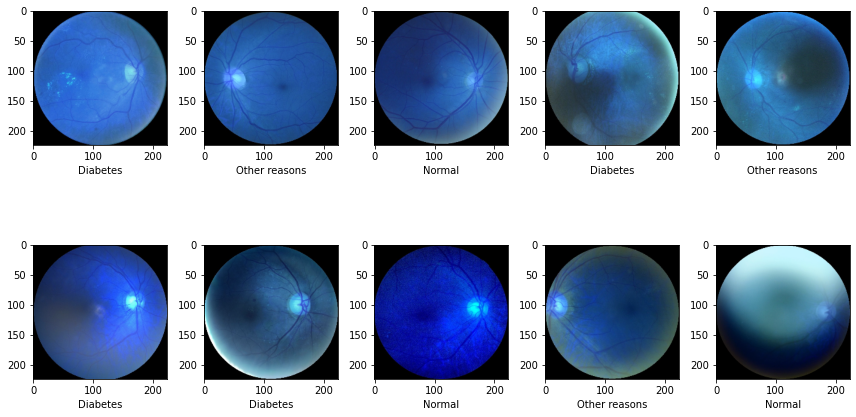

In [11]:
show_images()

## Creating our test and validation set

In [12]:
# Because of the way the labels were created, it's better to categorize them to prevent deceiving the model
X = np.array([i[0] for i in ds]).reshape(-1,image_size,image_size,3)
y = to_categorical([i[1] for i in ds])
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)
X_val,X_test,y_val,y_test = train_test_split(X_val, y_val, test_size=0.5)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(10439, 224, 224, 3)
(1305, 224, 224, 3)
(1305, 224, 224, 3)
(10439, 8)
(1305, 8)
(1305, 8)


## Building our VGG16 Model with all the 8 classes

In [13]:
model_3 = tf.keras.Sequential()

# add VGG16
model_3.add(VGG16(include_top=False, input_shape=(224,224,3)))
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(64))
model_3.add(tf.keras.layers.Activation('relu'))
model_3.add(tf.keras.layers.Dense(64))
model_3.add(tf.keras.layers.Activation('relu'))
model_3.add(tf.keras.layers.Dropout(0.5))
model_3.add(tf.keras.layers.Dense(8))
model_3.add(tf.keras.layers.Activation('softmax'))

2022-05-09 23:25:26.769334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 23:25:26.890205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 23:25:26.891077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 23:25:26.892272: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 1s 0us/step


In [14]:
optim_3 = tf.keras.optimizers.Adam(learning_rate = 0.00001)
model_3.compile(optimizer= optim_3, loss= 'categorical_crossentropy', metrics=['accuracy'])
training_3 = model_3.fit(x=X_train, y=y_train, batch_size=64, epochs=70, validation_data=(X_val, y_val))

2022-05-09 23:28:30.664452: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.
2022-05-09 23:28:32.267821: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.
2022-05-09 23:28:33.434966: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-05-09 23:28:35.113525: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


164/164 [==============================] - 82s 417ms/step - loss: 2.0050 - accuracy: 0.2762 - val_loss: 1.6667 - val_accuracy: 0.3586
Epoch 2/70
164/164 [==============================] - 64s 391ms/step - loss: 1.7401 - accuracy: 0.3338 - val_loss: 1.5910 - val_accuracy: 0.4015
Epoch 3/70
164/164 [==============================] - 64s 391ms/step - loss: 1.6830 - accuracy: 0.3646 - val_loss: 1.5072 - val_accuracy: 0.4276
Epoch 4/70
164/164 [==============================] - 64s 392ms/step - loss: 1.6071 - accuracy: 0.4033 - val_loss: 1.4709 - val_accuracy: 0.4644
Epoch 5/70
164/164 [==============================] - 64s 392ms/step - loss: 1.5494 - accuracy: 0.4290 - val_loss: 1.4337 - val_accuracy: 0.4636
Epoch 6/70
164/164 [==============================] - 64s 391ms/step - loss: 1.4999 - accuracy: 0.4433 - val_loss: 1.3778 - val_accuracy: 0.4736
Epoch 7/70
164/164 [==============================] - 64s 392ms/step - loss: 1.4115 - accuracy: 0.4852 - val_loss: 1.3441 - val_accuracy: 0.4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164/164 [==============================] - 64s 392ms/step - loss: 0.2875 - accuracy: 0.8809 - val_loss: 0.9432 - val_accuracy: 0.7824
Epoch 65/70
164/164 [==============================] - 64s 391ms/step - loss: 0.2782 - accuracy: 0.8869 - val_loss: 0.9235 - val_accuracy: 0.7870
Epoch 66/70
164/164 [==============================] - 64s 392ms/step - loss: 0.2796 - accuracy: 0.8881 - val_loss: 0.8664 - val_accuracy: 0.7816
Epoch 67/70
164/164 [==============================] - 64s 392ms/step - loss: 0.2699 - accuracy: 0.8889 - val_loss: 0.9278 - val_accuracy: 0.7854
Epoch 68/70
164/164 [==============================] - 64s 392ms/step - loss: 0.2742 - accuracy: 0.8928 - val_loss: 0.9031 - val_accuracy: 0.7893
Epoch 69/70
164/164 [==============================] - 64s 391ms/step - loss: 0.2734 - accuracy: 0.8894 - val_loss: 0.9988 - val_accuracy: 0.7816
Epoch 70/70
164/164 [==============================] - 64s 392ms/step - loss: 0.2770 - accuracy: 0.8838 - val_loss: 0.9824 - val_accurac

In [15]:
accuracy_3 = model_3.evaluate(X_test, y_test)
print(accuracy_3)
y_pred_3 = model_3.predict(X_test)
print(y_pred_3)

41/41 [==============================] - 5s 61ms/step - loss: 1.0116 - accuracy: 0.7479
[1.0115835666656494, 0.7478927373886108]
[[6.4579165e-03 1.0795123e-03 9.8480005e-03 ... 2.1556402e-03
  4.5080534e-03 9.6574134e-01]
 [1.7867981e-02 6.5887966e-03 1.7878118e-01 ... 2.0115683e-02
  8.8031776e-03 7.0094115e-01]
 [1.1967249e-02 3.9110851e-02 4.9500066e-01 ... 1.6202323e-02
  1.6811224e-02 3.7965792e-01]
 ...
 [7.1728928e-04 7.9448614e-03 5.7328795e-03 ... 2.7670605e-02
  2.7749015e-04 3.3256563e-03]
 [7.2382670e-03 8.0498885e-03 2.5795004e-01 ... 2.3771580e-02
  2.2085547e-02 6.5906245e-01]
 [9.3081119e-03 1.2377842e-02 2.4344298e-01 ... 1.7261285e-02
  1.4200628e-02 6.7812246e-01]]


In [16]:
print(f"Validation loss: {accuracy_3[0]}")
print(f"Validation accuracy: {accuracy_3[1]}")

Validation loss: 1.0115835666656494
Validation accuracy: 0.7478927373886108


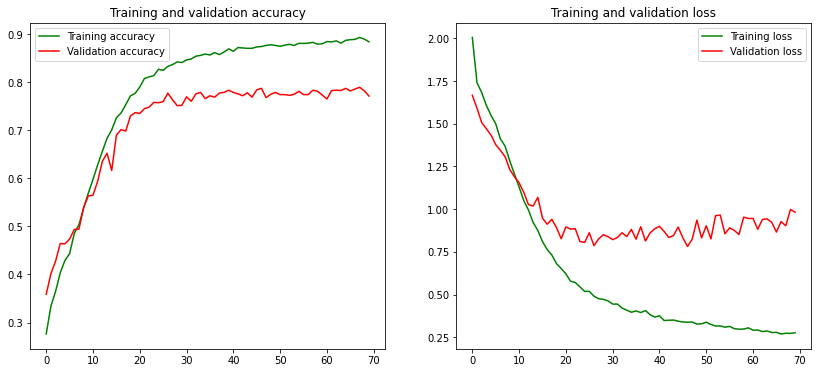

In [17]:
plot_accuracy_and_loss(training_3)

As we can see, the model is not overfitting

In [18]:
y_pred_3 = np.argmax(y_pred_3, axis=1)
y_test_3 = np.argmax(y_test, axis=1)

In [19]:
cm_3 = confusion_matrix(y_test_3, y_pred_3, labels= [0,1,2,3,4,5,6,7])


Normalized confusion matrix
[[0.94117647 0.00470588 0.01647059 0.00470588 0.00235294 0.
  0.         0.03058824]
 [0.         0.875      0.09375    0.         0.         0.015625
  0.         0.015625  ]
 [0.08708709 0.003003   0.69369369 0.01801802 0.         0.04204204
  0.003003   0.15315315]
 [0.07894737 0.         0.10526316 0.68421053 0.02631579 0.02631579
  0.         0.07894737]
 [0.02040816 0.         0.02040816 0.04081633 0.79591837 0.02040816
  0.         0.10204082]
 [0.06521739 0.         0.43478261 0.04347826 0.02173913 0.36956522
  0.         0.06521739]
 [0.         0.         0.05555556 0.05555556 0.         0.
  0.75       0.13888889]
 [0.11783439 0.01273885 0.21974522 0.03503185 0.01592357 0.00955414
  0.01592357 0.57324841]]


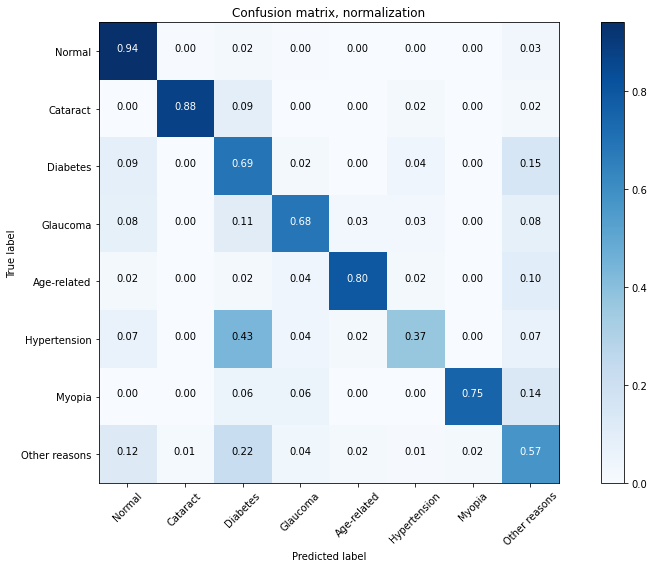

In [20]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(cm_3, classes=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"], 
                      title='Confusion matrix, normalization')


For Normal , Myopia, Other Reasons and Cataract, the algorithm did a good job identifying the fundus. Glaucoma, Diabetes and Age-related got an average performance. Hypertension had the worst performance. These results makes sense as we had a lot of images feeded to the model for rest of the categories where as Hypertension has the least amount of data (382 images) hence there was less data for the model to learn.  

In [21]:
print(classification_report(y_test_3, y_pred_3, target_names=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"]))

accuracy_score(y_test_3, y_pred_3, normalize=True)

               precision    recall  f1-score   support

       Normal       0.85      0.94      0.89       425
     Cataract       0.89      0.88      0.88        64
     Diabetes       0.68      0.69      0.69       333
     Glaucoma       0.51      0.68      0.58        38
  Age-related       0.83      0.80      0.81        49
 Hypertension       0.46      0.37      0.41        46
       Myopia       0.82      0.75      0.78        36
Other reasons       0.69      0.57      0.63       314

     accuracy                           0.75      1305
    macro avg       0.72      0.71      0.71      1305
 weighted avg       0.74      0.75      0.74      1305



0.7478927203065134

Seems like the best accuracy we could achieve 74.7% 

We can see that both the precision and recall have increased for all the fundus images

# USING PREDICTIONS OF PREVIOUS MODELS WITH AGE and SEX

In [23]:
data_csv.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,left_retinopathy,right_retinopathy,left_age-related,right_age-related,left_hypertensive,right_hypertensive,left_myopia,right_myopia,left_other,right_other
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,0,0,0,0,0,8
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,8,8
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,3,3,0,0,0,0,0,0,8,8
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,3,0,0,0,0,0,0,8,8
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,3,3,0,0,0,0,0,0,8,8


In [24]:
#create_dataset(image_category,label)
label_dict = {'N':0,"C":1,'D':2,'G':3,'A':4,'H':5,'M':6,'O':7}
labels = [label_dict[l[2]] for l in list(data_csv['labels'])]

X = []
for img in list(data_csv['filename']):
    image_path = os.path.join(dataset_dir,img)
    image = cv.imread(image_path,cv.IMREAD_COLOR)
    image = cv.resize(image,(image_size,image_size))
    X.append(np.array(image))
X = np.array(X).reshape(-1,image_size,image_size,3)

In [25]:
model_predictions = np.argmax(model_3.predict(X), axis=1)

2022-05-10 00:46:06.828745: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 962174976 exceeds 10% of free system memory.
2022-05-10 00:46:07.804253: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 962174976 exceeds 10% of free system memory.


In [26]:
df = pd.DataFrame()
df['Model_Predictions'] = model_predictions
df['Age'] = data_csv['Patient Age']
df['Male'] = [int(sex=="Male") for sex in list(data_csv['Patient Sex'])]
df['True_Label'] = labels

In [27]:
df

,Model_Predictions,Age,Male,True_Label
0,0,69,0,0
1,0,57,1,0
2,7,42,1,2
3,2,53,1,2
4,2,50,0,2
...,...,...,...,...
6387,2,63,1,2
6388,2,42,1,2
6389,2,54,1,2
6390,2,57,1,2


In [28]:
X = df[['Model_Predictions','Age','Male']].to_numpy()
y = df['True_Label'].to_numpy().transpose() # np.matrix(Y.to_numpy()).transpose()
m,n = X.shape

In [29]:
from keras.utils.np_utils import to_categorical

y_cat = to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2)

In [30]:
from keras.layers import Dropout

In [31]:
model = Sequential()
model.add(Dense(60, input_shape = (3,), activation = "relu"))
model.add(Dense(15, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation = "softmax"))
model.compile(tf.keras.optimizers.Adam(lr = 0.01), "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 60)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 128       
Total params: 1,283
Trainable params: 1,283
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(x_train, y_train, verbose=1, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
160/160 [==============================] - 1s 3ms/step - loss: 1.8169 - accuracy: 0.4256 - val_loss: 1.2806 - val_accuracy: 0.4535
Epoch 2/100
160/160 [==============================] - 0s 3ms/step - loss: 1.3290 - accuracy: 0.4794 - val_loss: 1.2182 - val_accuracy: 0.6208
Epoch 3/100
160/160 [==============================] - 0s 3ms/step - loss: 1.2914 - accuracy: 0.5343 - val_loss: 1.1789 - val_accuracy: 0.6169
Epoch 4/100
160/160 [==============================] - 0s 3ms/step - loss: 1.2863 - accuracy: 0.5394 - val_loss: 1.1576 - val_accuracy: 0.6208
Epoch 5/100
160/160 [==============================] - 0s 3ms/step - loss: 1.2888 - accuracy: 0.5421 - val_loss: 1.1634 - val_accuracy: 0.6208
Epoch 6/100
160/160 [==============================] - 0s 3ms/step - loss: 1.2736 - accuracy: 0.5463 - val_loss: 1.1611 - val_accuracy: 0.6208
Epoch 7/100
160/160 [==============================] - 0s 3ms/step - loss: 1.2748 - accuracy: 0.5443 - val_loss: 1.1652 - val_accuracy: 0.6208

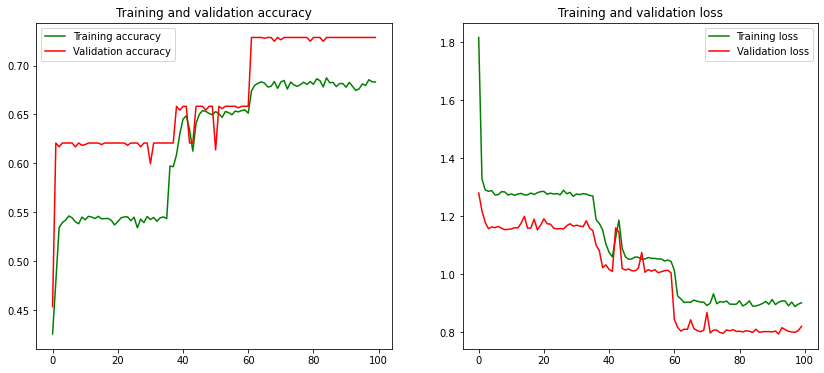

In [33]:
plot_accuracy_and_loss(history)